## Подготовка датасета

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

from sklearn.model_selection import train_test_split

import mpl_toolkits.mplot3d  # noqa: F401
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score

from scipy.cluster.hierarchy import linkage, dendrogram

In [ ]:
%pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
regensburg_pediatric_appendicitis = fetch_ucirepo(id=938)

In [ ]:
# data (as pandas dataframes)
x = regensburg_pediatric_appendicitis.data.features
y = regensburg_pediatric_appendicitis.data.targets

In [ ]:
df = pd.merge(
    x,
    y,
    how='inner',
    left_index=True, right_index=True
)
df.head(5)

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings,Management,Severity,Diagnosis
0,12.68,16.9,female,148.0,37.0,3.0,4.0,3.0,yes,7.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conservative,uncomplicated,appendicitis
1,14.10,31.9,male,147.0,69.5,2.0,5.0,4.0,no,NaN,...,NaN,NaN,NaN,NaN,yes,NaN,NaN,conservative,uncomplicated,no appendicitis
2,14.14,23.3,female,163.0,62.0,4.0,5.0,3.0,no,NaN,...,NaN,NaN,NaN,NaN,yes,yes,NaN,conservative,uncomplicated,no appendicitis
3,16.37,20.6,female,165.0,56.0,3.0,7.0,6.0,no,NaN,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,conservative,uncomplicated,no appendicitis
4,11.08,16.9,female,163.0,45.0,3.0,5.0,6.0,yes,7.0,...,NaN,NaN,NaN,NaN,NaN,yes,NaN,conservative,uncomplicated,appendicitis


In [ ]:
df = df.drop(df[df['Management'] == 'simultaneous appendectomy'].index)
df = df.drop(['Severity', 'Diagnosis'], axis=1)

In [ ]:
for column in df.select_dtypes(include=['number']).columns:
  df[column].fillna(df[column].mean(), inplace=True)
for column in df.select_dtypes(include=['object']).columns:
  df[column].fillna('no', inplace=True)

In [ ]:
df = df.drop(df[df['Management'] == 'no'].index)
cols = df.columns

In [ ]:
vals = y.unique()
vals

array(['conservative', 'primary surgical', 'secondary surgical'],
      dtype=object)

In [ ]:
y = df['Management'].replace(vals, [0, 1, 2])
x = df.drop('Management', axis=1)
cols_for_clusters = x.columns
x_copy = x.copy()

In [ ]:
cat_columns = x.select_dtypes(['object']).columns
x[cat_columns] = x[cat_columns].apply ( lambda x: pd.factorize (x)[ 0 ])
x=(x-x.min())/(x.max()-x.min())
x.head(5)

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Alvarado_Score,Paedriatic_Appendicitis_Score,Appendix_on_US,Appendix_Diameter,...,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,0.690632,0.299044,0.0,0.683453,0.333603,0.074074,0.4,0.3,0.0,0.307692,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.767974,0.793604,0.5,0.676259,0.661753,0.037037,0.5,0.4,1.0,0.354032,...,0.0,1.0,0.038462,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.770153,0.510056,0.0,0.791367,0.586026,0.111111,0.5,0.3,1.0,0.354032,...,0.0,1.0,0.038462,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.891612,0.421035,0.0,0.805755,0.525444,0.074074,0.7,0.6,1.0,0.354032,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.603486,0.299044,0.0,0.791367,0.414378,0.074074,0.5,0.6,0.0,0.300699,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
y

,Management
0,0
1,0
2,0
3,0
4,0
...,...
777,1
778,2
779,1
780,1


# Линейные методы уменьшения размерности (Linear Dimensionality Reduction Methods)




### Метод главных компонентов (Principal Component Analysis, PCA)


In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA

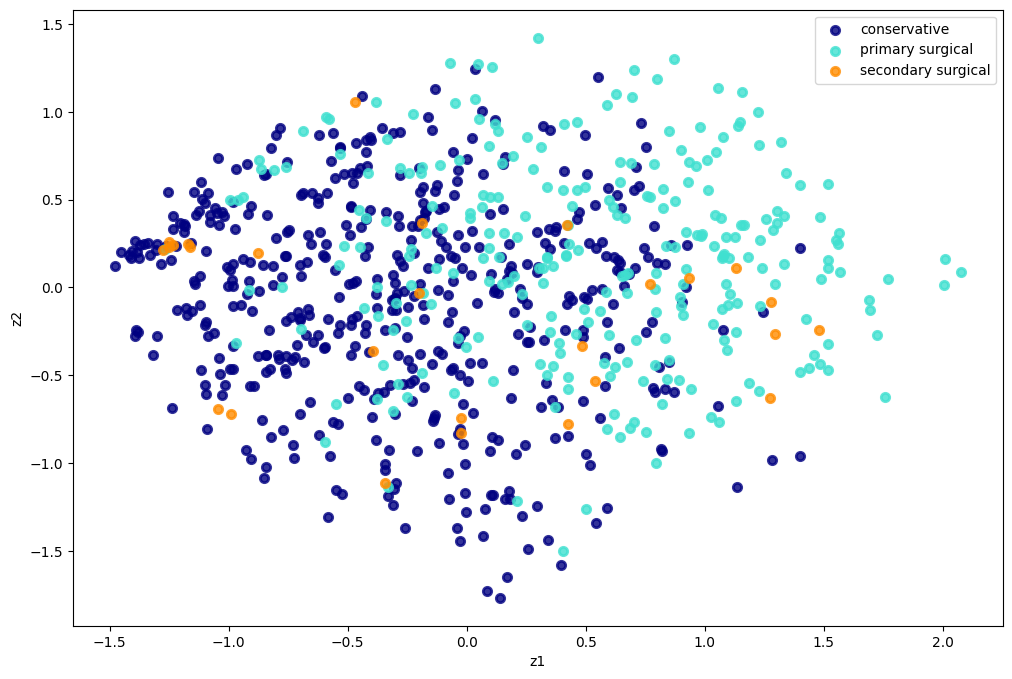

In [ ]:
pca = PCA(n_components=3)
X_new = pca.fit(x).transform(x)


plt.figure(figsize=(12,8))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], cols_for_clusters):
    plt.scatter(
        X_new[y == i, 0], X_new[y == i, 1], color=color, alpha=0.8, lw=lw, label=vals[i]
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([0.14488545, 0.08713897, 0.08055814, 0.05960653, 0.05536437])

Первые главные компоненты сохраняют 14% дисперсии набора данных iris.




### Независисый анализ компонентов (Independent Component Analysis, ICA)

In [ ]:
from sklearn.decomposition import FastICA

fast_ica = FastICA(n_components=3)
X_new = fast_ica.fit_transform(x)

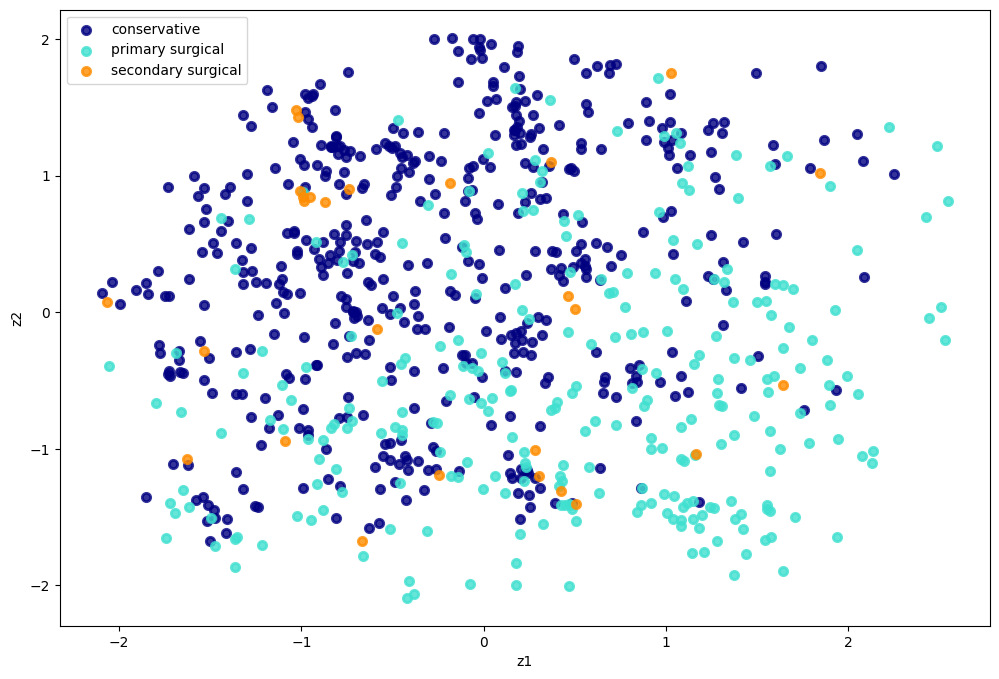

In [ ]:
plt.figure(figsize=(12,8))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], cols_for_clusters):
    plt.scatter(
        X_new[y == i, 0], X_new[y == i, 1], color=color, alpha=0.8, lw=lw, label=vals[i]
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

#Нелинейные методы уменьшения размерности

### Kernel PCA

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_new = rbf_pca.fit_transform(x)

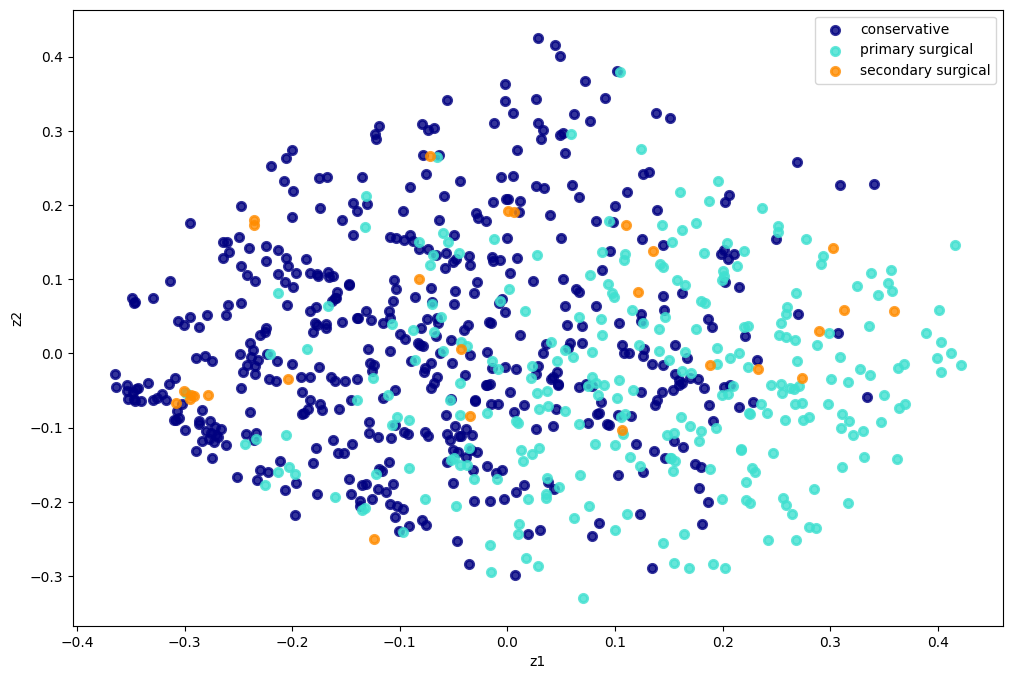

In [ ]:
plt.figure(figsize=(12,8))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], cols_for_clusters):
    plt.scatter(
        X_new[y == i, 0], X_new[y == i, 1], color=color, alpha=0.8, lw=lw, label=vals[i]
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

### tSNE



In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
X_new = tsne.fit_transform(x)

In [ ]:
# Вывод результатов
print('Initial Shape of X: ', x.shape)
print('New Shape of X: ', X_new.shape)
print('Kullback-Leibler divergence after optimization: ', tsne.kl_divergence_)
print('No. of iterations: ', tsne.n_iter_)
#print('Embedding vectors: ', tsne.embedding_)

Initial Shape of X:  (780, 53)
New Shape of X:  (780, 3)
Kullback-Leibler divergence after optimization:  1.2312463521957397
No. of iterations:  699


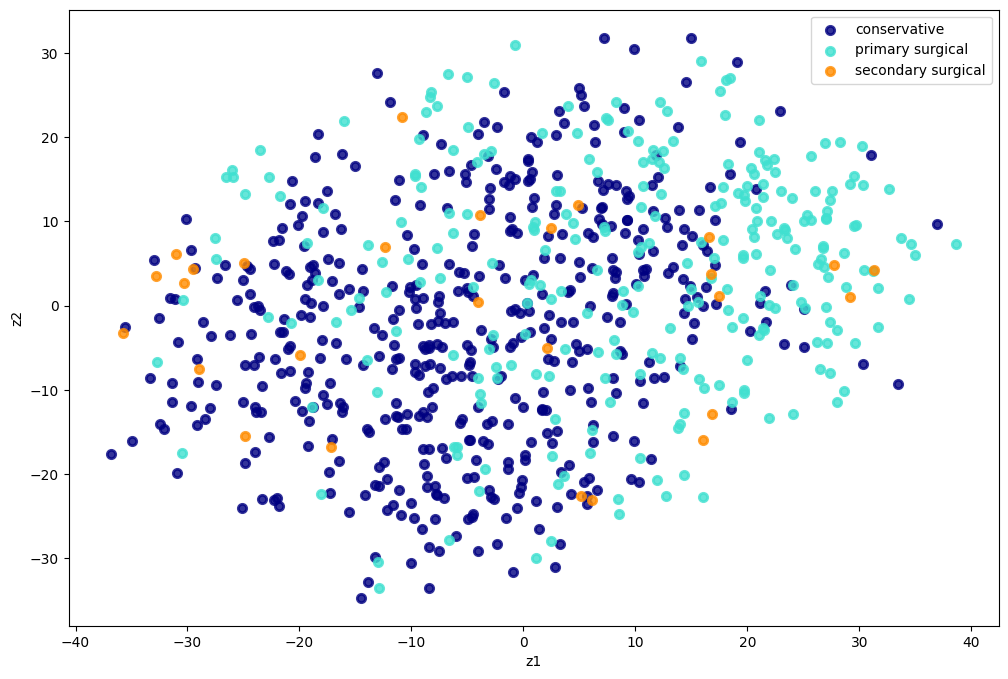

In [ ]:
plt.figure(figsize=(12,8))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], cols_for_clusters):
    plt.scatter(
        X_new[y == i, 0], X_new[y == i, 1], color=color, alpha=0.8, lw=lw, label=vals[i]
    )

plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

## DBSCAN для кластеризации

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score

In [ ]:
dbscan_cluster1 = DBSCAN(eps = 0.5, min_samples = 3)
X_new = dbscan_cluster1.fit(x)

In [ ]:
# Number of Clusters
labels=dbscan_cluster1.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan_cluster1.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(y, labels))

Estimated no. of clusters: 3
Estimated no. of noise points: 770
v_measure = 0.04936526499048155


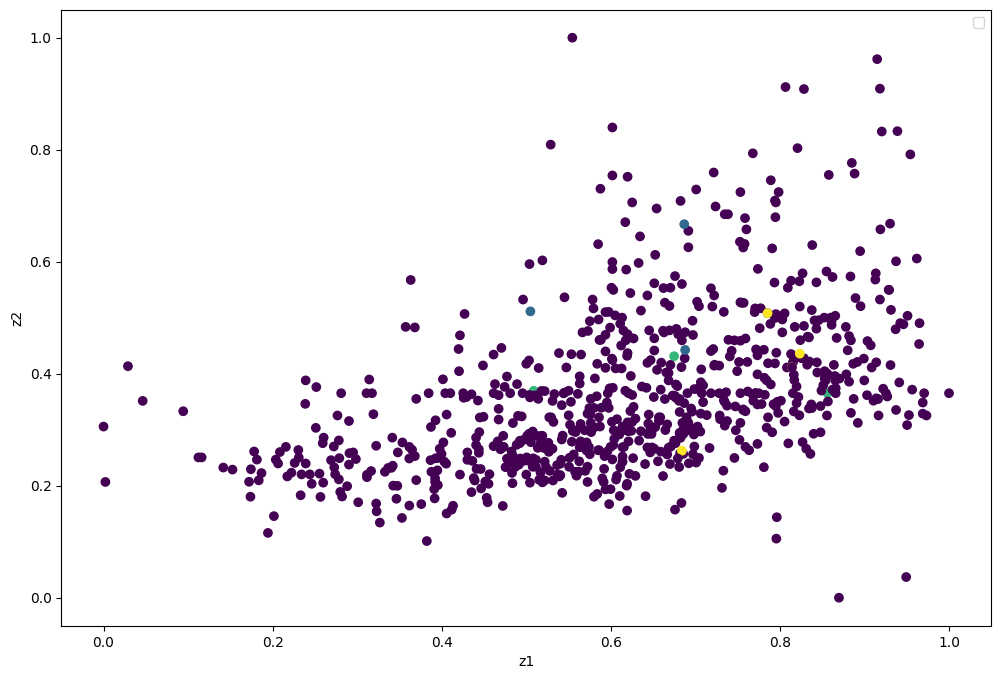

In [ ]:
plt.figure(figsize=(12,8))
colors = ["navy", "turquoise", "darkorange"]
lw = 2

plt.scatter(
        x[cols[0]], x[cols[1]],c=dbscan_cluster1.labels_
    )

plt.legend(loc="best", shadow=False, scatterpoints=2)
plt.xlabel("z1")
plt.ylabel("z2")
plt.show()

In [ ]:
from sklearn.neighbors import NearestNeighbors

min_samples = 3

knn = NearestNeighbors(n_neighbors = min_samples, metric = 'l2')
knn.fit(x)

dists, inds = knn.kneighbors(x)
dists_ar = dists[:, 1:min_samples].mean(axis=1)
dists_ar.sort()

In [ ]:
import sklearn
#возможные метрики расстояния
sklearn.metrics.pairwise.distance_metrics()

{'cityblock': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'cosine': <function sklearn.metrics.pairwise.cosine_distances(X, Y=None)>,
 'euclidean': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'haversine': <function sklearn.metrics.pairwise.haversine_distances(X, Y=None)>,
 'l2': <function sklearn.metrics.pairwise.euclidean_distances(X, Y=None, *, Y_norm_squared=None, squared=False, X_norm_squared=None)>,
 'l1': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'manhattan': <function sklearn.metrics.pairwise.manhattan_distances(X, Y=None)>,
 'precomputed': None,
 'nan_euclidean': <function sklearn.metrics.pairwise.nan_euclidean_distances(X, Y=None, *, squared=False, missing_values=nan, copy=True)>}

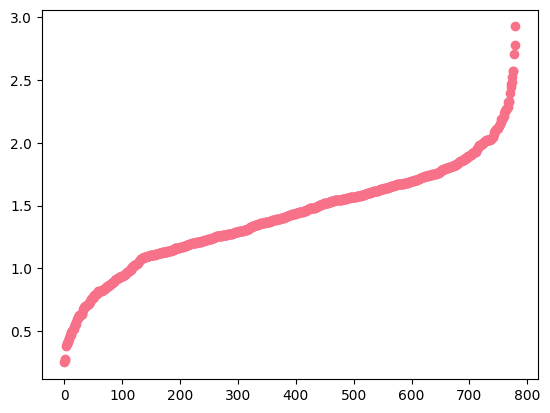

In [ ]:
plt.scatter(x = range(len(dists_ar)), y=dists_ar)
plt.show()

eps  выбирают в точке изгиба графика

## DBSCAN для определения выбросов

In [ ]:
dbscan = DBSCAN(eps = 2, min_samples = min_samples)
print(dbscan)

DBSCAN(eps=2, min_samples=3)


In [ ]:
pred = dbscan.fit_predict(x)

In [ ]:
# Number of Clusters
labels=dbscan.labels_
N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

# Identify Noise
n_noise = list(dbscan.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

# Calculating v_measure
print('v_measure =', v_measure_score(y, labels))

Estimated no. of clusters: 1
Estimated no. of noise points: 44
v_measure = 0.07399887191816665


In [ ]:
# у анномалий - класс -1, ищем все номера строк с таким классом, потом отбираем эти строки из начального набора данных

anom_index = [i for i in range(len(pred)) if pred[i] == -1]
values = x.loc[anom_index]

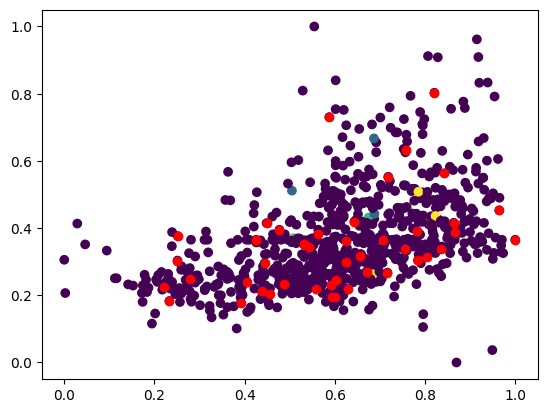

In [ ]:
plt.scatter( x[cols[0]], x[cols[1]],c=dbscan_cluster1.labels_)
plt.scatter(values[cols[0]], values[cols[1]], color='r')
plt.show()